In [1]:
import numpy as np
from tic_env import TictactoeEnv, OptimalPlayer
from math import pow, inf
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# map a grid/action pair to the index of the corresponding q value in self.qs
three_power = np.array( [pow(3,i) for i in range(9)] )
three_power_nine = pow(3,9)
def sa_to_id(grid,action,player):
    # map grid to a 9 digit trinary number, then change the number to decimal, then add action * 3^9, finally add 9*3^9 if player is O
    flat_grid = grid.flatten()
    digits = flat_grid + 1
    multiplied = np.multiply(digits,three_power)
    index = np.sum(multiplied)
    index += three_power_nine * action
    if (player == 'O'):
        index += 177147
    return int(index)
def sas_to_ids(grid,actions,player):
    flat_grid = grid.flatten()
    digits = flat_grid + 1
    multiplied = np.multiply(digits,three_power)
    s = np.sum(multiplied)
    if (player == 'O'):
        s += 177147
    ids = np.full(len(actions),s)
    for i in range(len(actions)):
        ids[i] += three_power_nine * actions[i]
    return ids.astype(int)
        


class QPlayer:
    '''
    the player stores the Q value of the grid/action pair when he's X as well as when he's O
    not every grid and action are valid. For example, grid where there's 3 O and zero X, or a action that place piece on existing piece.
    We keep all available grid and action never the less, for simplicity.
    '''
    def __init__(self,epsilon=0.2,player='X'):
        self.player = player
        self.qs = np.zeros(177147*2)
        self.previous_q = -1
        self.lr = 0.05
        self.d_factor = 0.99
        self.epsi = epsilon
    def set_player(self,player):
        self.player = player
    # choose action and update q value of previous s,a pair
    def act(self, grid, reward):
        #first, find all available actions
        actions = [a for a in range(9) if grid[(int(a/3), a % 3)] == 0]
        ids = sas_to_ids(grid,actions,self.player)
        possible_qs = [self.qs[i] for i in ids]
        best = np.argmax(possible_qs)
        best_a = actions[ best ]
        highest_q = possible_qs[best]
        #then, update q value from previous time step
        if not self.previous_q == -1:
            delta = self.lr * (reward + self.d_factor * highest_q - self.qs[self.previous_q])
            self.qs[self.previous_q] = self.qs[self.previous_q] + delta
        #then, choose a action according to policy, and save current q value's index
        if random.uniform(0, 1) > self.epsi:
            at = best_a
        else:
            if len(actions) > 1: actions.pop(best)
            at = random.choice(actions)
        self.previous_q = sa_to_id(grid,at,self.player)
               
        return at
    # called when agent reach terminal state
    def terminal(self, reward):
        if self.previous_q == -1:
            return
        delta = self.lr * (reward + 0 - self.qs[self.previous_q])
        self.qs[self.previous_q] = self.qs[self.previous_q] + delta
        #set previous_q to -1 because game will restart
        self.previous_q = -1
    # choose a action according to q value with greedy policy, and not update any q value
    def test_act(self, grid):
        actions = [a for a in range(9) if grid[(int(a/3), a % 3)] == 0]
        ids = sas_to_ids(grid,actions,self.player)
        possible_qs = [self.qs[i] for i in ids]
        best = np.argmax(possible_qs)
        best_a = actions[ best ]
        return best_a
   

In [41]:
class DecreasingQPlayer(QPlayer):
    def __init__(self,n_star, player = 'X'):
        super().__init__(player = player)
        self.epsimin = 0.1
        self.epsimax = 0.8
        self.n_star = n_star
        self.n = 0
        self.update_epsi()
    def update_epsi(self):
        self.n+=1
        second_term = self.epsimax * (1. - self.n/self.n_star)
        self.epsi = max(self.epsimin, second_term)
    def terminal(self, reward):
        super().terminal(reward)
        self.update_epsi()

In [42]:
class SelfQPlayer(QPlayer):
    # in this class self.previous_q have no actual meaning, its replaced by self.previousq_X and self.previousq_O, these record the last
    # s,a pair the agent select as X or O. with a new state s', the agent will update the s that has the same player as s'
    def __init__(self,epsilon=0.2):
        super().__init__(epsilon)
        self.previous_q_X = -1
        self.previous_q_O = -1
    # the typical workflow: setplayer(X) -> act() -> setplayer(O) -> act() -> setplayer(X) -> act()...
    def act(self, grid, reward):
        #store previous
        if self.player == 'X':
            self.previous_q = self.previous_q_X
        else:
            self.previous_q = self.previous_q_O
        at = super().act(grid,reward)
        if self.player == 'X':
            self.previous_q_X = self.previous_q
        else:
            self.previous_q_O = self.previous_q
        return at
    def terminal(self,winner):
        if winner == 'X':
            reward_X = 1
            reward_O = -1
        elif winner == 'O':
            reward_X = -1
            reward_O = 1
        else:
            reward_X = 0
            reward_O = 0
            
        if not self.previous_q_X == -1:
            delta = self.lr * (reward_X + 0 - self.qs[self.previous_q_X])
            self.qs[self.previous_q_X] = self.qs[self.previous_q_X] + delta
        if not self.previous_q_O == -1:
            delta = self.lr * (reward_O + 0 - self.qs[self.previous_q_O])
            self.qs[self.previous_q_O] = self.qs[self.previous_q_O] + delta
        #set previous_q to -1 because game will restart
        self.previous_q_X = -1
        self.previous_q_O = -1

In [43]:
class DecreasingSelfQPlayer(QPlayer):
    # in this class self.previous_q have no actual meaning, its replaced by self.previousq_X and self.previousq_O, these record the last
    # s,a pair the agent select as X or O. with a new state s', the agent will update the s that has the same player as s'
    def __init__(self,n_star):
        super().__init__()
        self.previous_q_X = -1
        self.previous_q_O = -1
        self.epsimin = 0.1
        self.epsimax = 0.8
        self.n_star = n_star
        self.n = 0
        self.update_epsi()
    def update_epsi(self):
        self.n+=1
        second_term = self.epsimax * (1. - self.n/self.n_star)
        self.epsi = max(self.epsimin, second_term)
    # the typical workflow: setplayer(X) -> act() -> setplayer(O) -> act() -> setplayer(X) -> act()...
    def act(self, grid, reward):
        #store previous
        if self.player == 'X':
            self.previous_q = self.previous_q_X
        else:
            self.previous_q = self.previous_q_O
        at = super().act(grid,reward)
        if self.player == 'X':
            self.previous_q_X = self.previous_q
        else:
            self.previous_q_O = self.previous_q
        return at
    def terminal(self,winner):
        if winner == 'X':
            reward_X = 1
            reward_O = -1
        elif winner == 'O':
            reward_X = -1
            reward_O = 1
        else:
            reward_X = 0
            reward_O = 0
            
        if not self.previous_q_X == -1:
            delta = self.lr * (reward_X + 0 - self.qs[self.previous_q_X])
            self.qs[self.previous_q_X] = self.qs[self.previous_q_X] + delta
        if not self.previous_q_O == -1:
            delta = self.lr * (reward_O + 0 - self.qs[self.previous_q_O])
            self.qs[self.previous_q_O] = self.qs[self.previous_q_O] + delta
        #set previous_q to -1 because game will restart
        self.previous_q_X = -1
        self.previous_q_O = -1
        self.update_epsi()

In [38]:
grid = np.array([[1.,-1.,0.],[0.,0.,1.],[-1.,0.,1.]])

print(sa_to_id(grid,3,'X') )
sas_to_ids(grid,[1,3,4],'X')

74963


array([35597, 74963, 94646])

In [39]:
[123,121,22]

[123, 121, 22]

In [40]:

np.sum(np.array([0.,1.]))

1.0

## 2.1 Learning from Experts
### Question1

In [23]:
# compatible input: QPlayer, DecreasingQPlayer, SelfQPlayer
def measure(player_pi,opt = True):
    env = TictactoeEnv()
    if opt:
        player_opt = OptimalPlayer(epsilon=0.)
    else:
        player_opt = OptimalPlayer(epsilon = 1.)
    num_lose = 0
    num_win = 0
    for i in range(500):
        #each game
        random.seed(i)
        env.reset()
        grid, _, __ = env.observe()
        if (i<250):
            player_opt.set_player('O')
            player_pi.set_player('X')
        else:
            player_opt.set_player('X')
            player_pi.set_player('O')
        for j in range(9):
            #each move
            if env.current_player == player_opt.player:
                move = player_opt.act(grid)
            else:
                move = player_pi.test_act(grid)
            grid, end, winner = env.step(move, print_grid=False)
            if end:
                if winner == player_pi.player: num_win += 1
                if winner == player_opt.player: num_lose += 1
                break
    return (num_win - num_lose)/500

In [24]:
#compatable input: QPlayer, DecreasingQPlayer
def train(epsi_opt,player_q,ms = False):# ms stands for measure
    env = TictactoeEnv()
    turns = np.array(['X','O'])
    player_opt = OptimalPlayer(epsilon=epsi_opt)
    average_rewards = []
    period_rewards = []
    if ms:
        m_opt = []
        m_rand = []
    for i in tqdm(range(20000)):
        #each game
        env.reset()
        grid, _, __ = env.observe()
        turns = turns[[1,0]]
        player_opt.set_player(turns[0])
        player_q.set_player(turns[1])
        for j in range(9):
            #each move
            if env.current_player == player_opt.player:
                move = player_opt.act(grid)
            else:
                move = player_q.act(grid,0)

            grid, end, winner = env.step(move, print_grid=False)

            if end:
                if winner == player_q.player: reward = 1
                elif winner == player_opt.player: reward = -1
                else: reward = 0
                player_q.terminal(reward)
                break
        period_rewards.append(reward)               
        if i%250 == 249:
            average_rewards.append(np.mean(period_rewards))
            period_rewards = []
            if ms:
                m_opt.append(measure(player_q))
                m_rand.append(measure(player_q, False))
    if ms:
        return {
            'average rewards':average_rewards,
            'm opt':m_opt,
            'm rand':m_rand
        }
    else:
        return average_rewards

In [32]:
player_q = QPlayer(epsilon= 0.5)
average_rewards = train(0.5,player_q)

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:48<00:00, 408.29it/s]


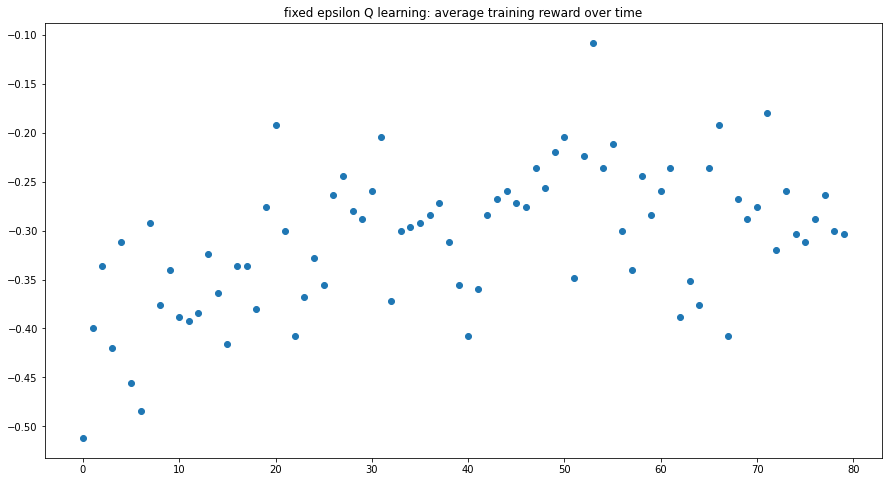

In [33]:
fig,ax = plt.subplots(figsize = (15,8))
ax.scatter(range(len(average_rewards)),average_rewards)
ax.set_title("fixed epsilon Q learning: average training reward over time");

Yes, the agent learnt to play tictactoe to some extent, but not very well. I choose epsilon to be 0.5

## 2.1.1 Decreasing Exploration
### question2

In [ ]:
n_stars = [1,10000,20000,30000,40000]
decreasing_players = [DecreasingQPlayer(ns) for ns in n_stars]
results = [train(0.5, player, True) for player in decreasing_players]

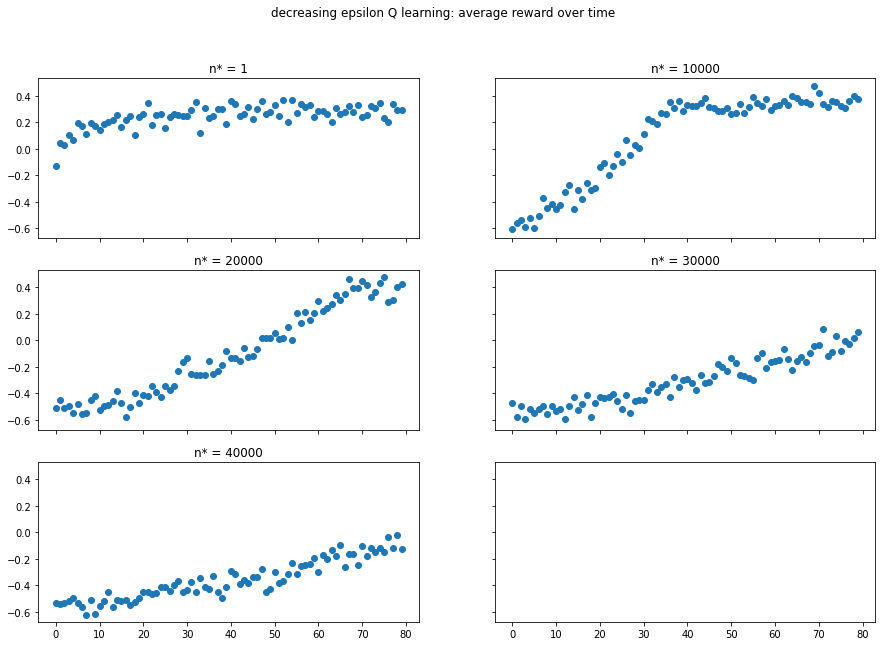

In [44]:
rewards = [r['average rewards'] for r in results]
fig, axs = plt.subplots(3, 2,figsize=(15, 10), sharex=True, sharey=True)
for i in range(5):
    axs[(int(i/2), i % 2)].scatter(range(len(rewards[i])),rewards[i])
    axs[(int(i/2), i % 2)].set_title("n* = {}".format(n_stars[i]))
fig.suptitle("decreasing epsilon Q learning: average reward over time");

Decreasing n\* does help with training if n\* is choosed correctly. When n\* = 10000, the average reward reached a steady 0.4 comparing with -0.3 when epsilon is fixed.

epsilon will start at epsilon max, then reduce to epsilon min over the course of roughly n\* games, after that it will be fixed at epsilon min. In other words, the agent change from high exploration to high exploitation over n\* games. The more exploration the agent does, the more informed it will be, the more exploitation it does, the better reward it get with his current information.

As a result of the change, we see a steadily increasing reward over n\* games. Then reward remain rather constant, and its level depends on how many exploration the agent has previously did, e.g. n\*=10000's constant reward is higher than when n\* is 1. Because the latter has done close to zero exploration

### Question3

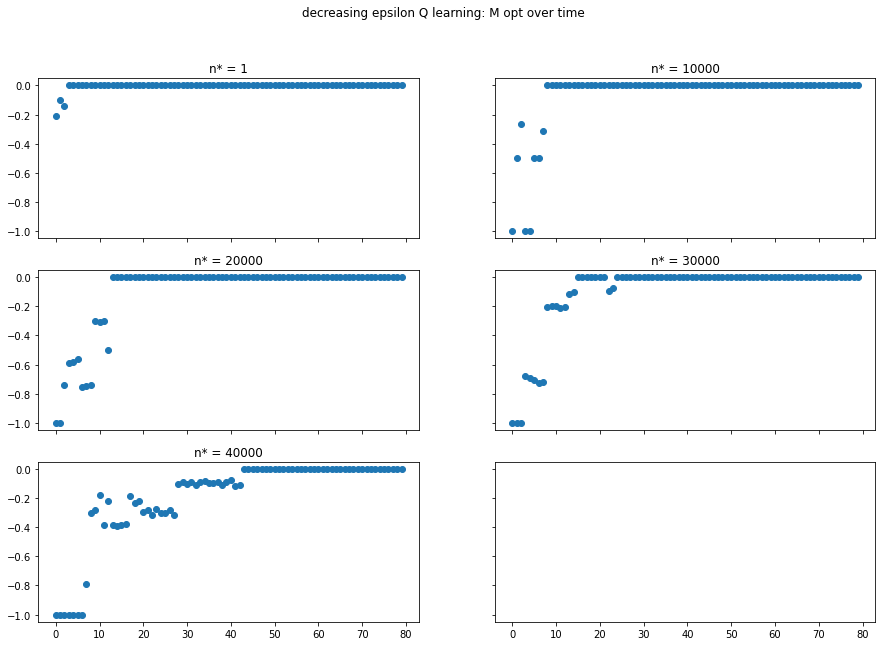

In [45]:
m_optimals = [r['m opt'] for r in results]
fig, axs = plt.subplots(3, 2,figsize=(15, 10), sharex=True, sharey=True)
for i in range(5):
    axs[(int(i/2), i % 2)].scatter(range(len(m_optimals[i])),m_optimals[i])
    axs[(int(i/2), i % 2)].set_title("n* = {}".format(n_stars[i]))
fig.suptitle("decreasing epsilon Q learning: M opt over time");

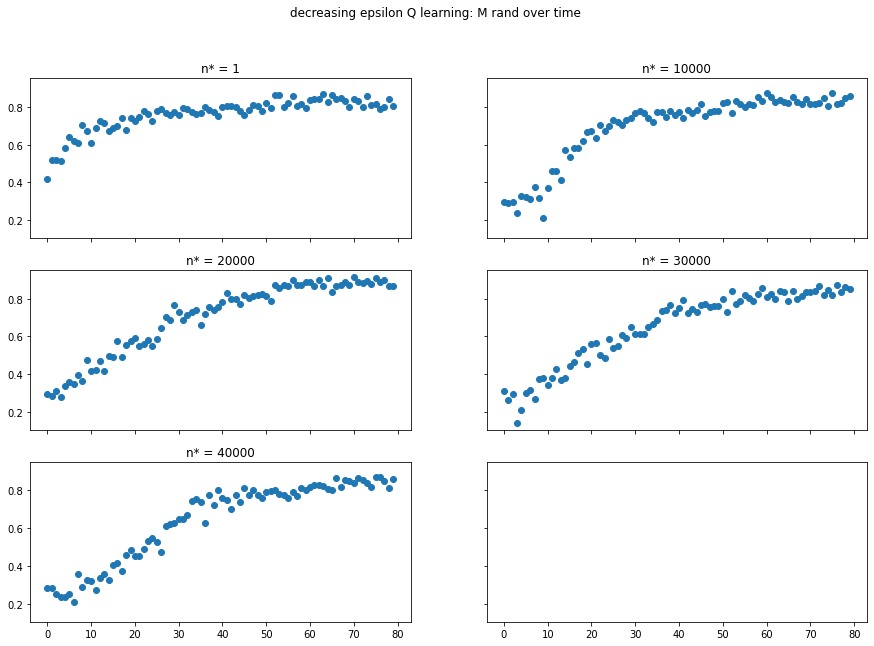

In [46]:
m_randoms = [r['m rand'] for r in results]
fig, axs = plt.subplots(3, 2,figsize=(15, 10), sharex=True, sharey=True)
for i in range(5):
    axs[(int(i/2), i % 2)].scatter(range(len(m_randoms[i])),m_randoms[i])
    axs[(int(i/2), i % 2)].set_title("n* = {}".format(n_stars[i]))
fig.suptitle("decreasing epsilon Q learning: M rand over time");

### 2.1.2 Good Expert and Bad Expert
#### Question 4

In [6]:
best_ns = 20000
epsi_opts = [0.,0.25,0.5,0.75,1.]
good_bad_players = []
results = []
for e in epsi_opts:
    p = DecreasingQPlayer(best_ns)
    good_bad_players.append(p)
    r = train(e,p,True)
    results.append(r)

100%|█████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:40<00:00, 71.36it/s]


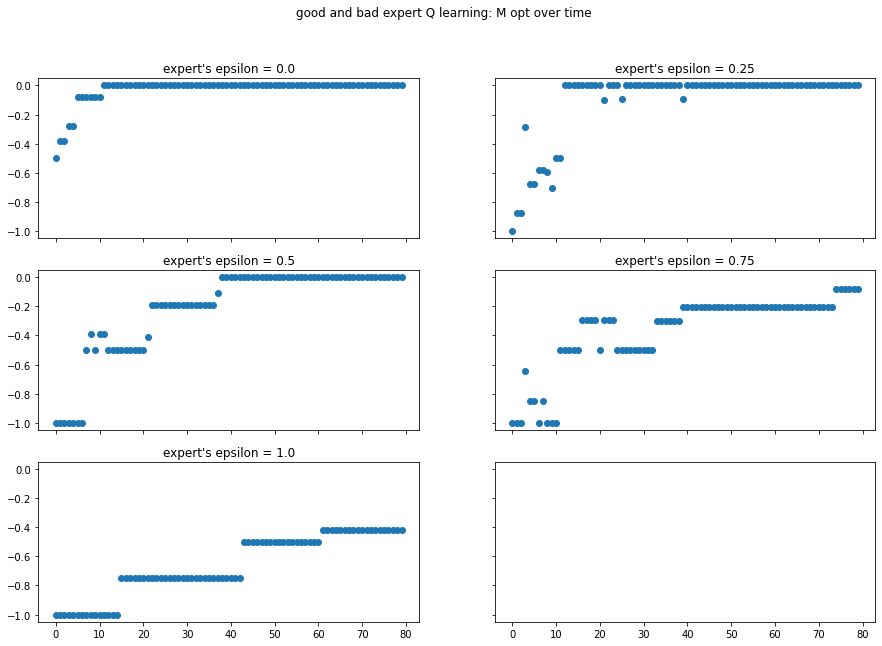

In [9]:
m_optimals = [r['m opt'] for r in results]
fig, axs = plt.subplots(3, 2,figsize=(15, 10), sharex=True, sharey=True)
for i in range(5):
    axs[(int(i/2), i % 2)].scatter(range(len(m_optimals[i])),m_optimals[i])
    axs[(int(i/2), i % 2)].set_title("expert's epsilon = {}".format(epsi_opts[i]))
fig.suptitle("good and bad expert Q learning: M opt over time");

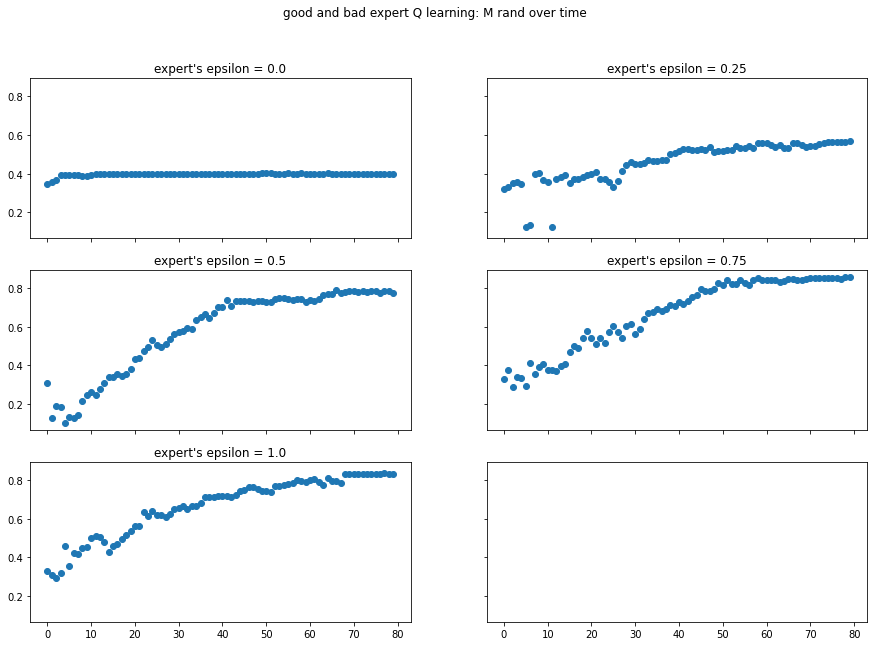

In [11]:
m_randoms = [r['m rand'] for r in results]
fig, axs = plt.subplots(3, 2,figsize=(15, 10), sharex=True, sharey=True)
for i in range(5):
    axs[(int(i/2), i % 2)].scatter(range(len(m_randoms[i])),m_randoms[i])
    axs[(int(i/2), i % 2)].set_title("expert's epsilon = {}".format(epsi_opts[i]))
fig.suptitle("good and bad expert Q learning: M rand over time");

### question 5


### question 6
No, because the two agents are trained by playing against different player. Their learnt Q value must therefore have different meaning. In particular, agent 1 's Q value is the expected total reward playing against Opt(0), and agent 2's Q value is the expected total reward playing against Opt(1). For instance, agent 1 may have a high Q-value for blocking action, and agent 2 may not, because his opponent is only a random player
## 2.2 Learning by Self Practice
### Question 7

In [28]:
def self_train(player_q):# ms stands for measure
    env = TictactoeEnv()
    m_opt = []
    m_rand = []
    for i in tqdm(range(20000)):
        #each game
        env.reset()
        grid, _, __ = env.observe()
        for j in range(9):
            #each move
            player_q.set_player(env.current_player)
            move = player_q.act(grid,0)

            grid, end, winner = env.step(move, print_grid=False)

            if end:
                player_q.terminal(winner)
                break
        if i%250 == 249:
            m_opt.append(measure(player_q))
            m_rand.append(measure(player_q, False))

    return {
        'm opt':m_opt,
        'm rand':m_rand
    }



In [31]:
epsilons = [0.,0.25,0.5,0.75]
self_players = [SelfQPlayer(e) for e in epsilons]
results = [self_train(p) for p in self_players]

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [02:49<00:00, 118.20it/s]


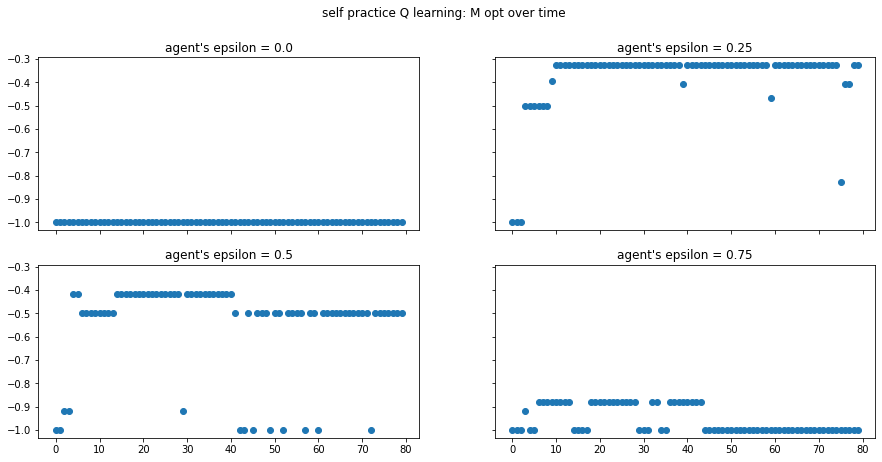

In [33]:
m_optimals = [r['m opt'] for r in results]
fig, axs = plt.subplots(2, 2,figsize=(15, 7), sharex=True, sharey=True)
for i in range(4):
    axs[(int(i/2), i % 2)].scatter(range(len(m_optimals[i])),m_optimals[i])
    axs[(int(i/2), i % 2)].set_title("agent's epsilon = {}".format(epsilons[i]))
fig.suptitle("self practice Q learning: M opt over time");

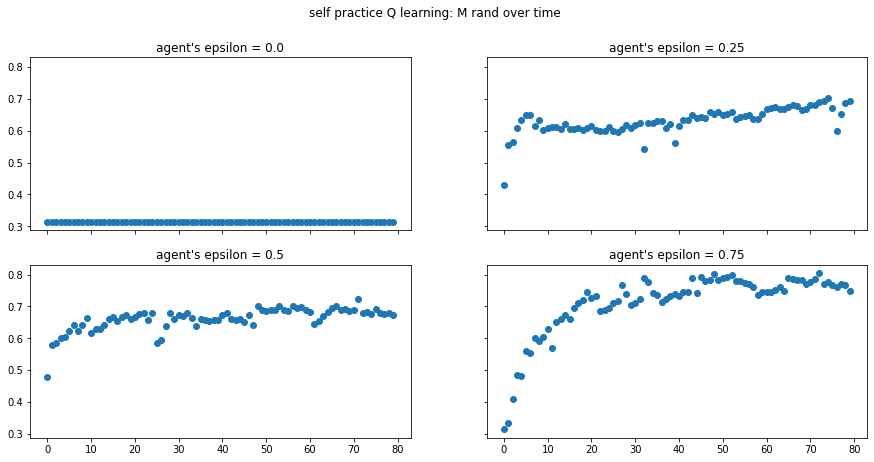

In [34]:
m_randoms = [r['m rand'] for r in results]
fig, axs = plt.subplots(2, 2,figsize=(15, 7), sharex=True, sharey=True)
for i in range(4):
    axs[(int(i/2), i % 2)].scatter(range(len(m_randoms[i])),m_randoms[i])
    axs[(int(i/2), i % 2)].set_title("agent's epsilon = {}".format(epsilons[i]))
fig.suptitle("self practice Q learning: M rand over time");

### Question 8

In [44]:
n_stars = [1,10000,20000,30000,40000]
decreasing_self_players = [DecreasingSelfQPlayer(ns) for ns in n_stars]
results = [self_train(p) for p in decreasing_self_players]

100%|█████████████████████████████████████████████████████████████████████████████| 20000/20000 [11:23<00:00, 29.26it/s]


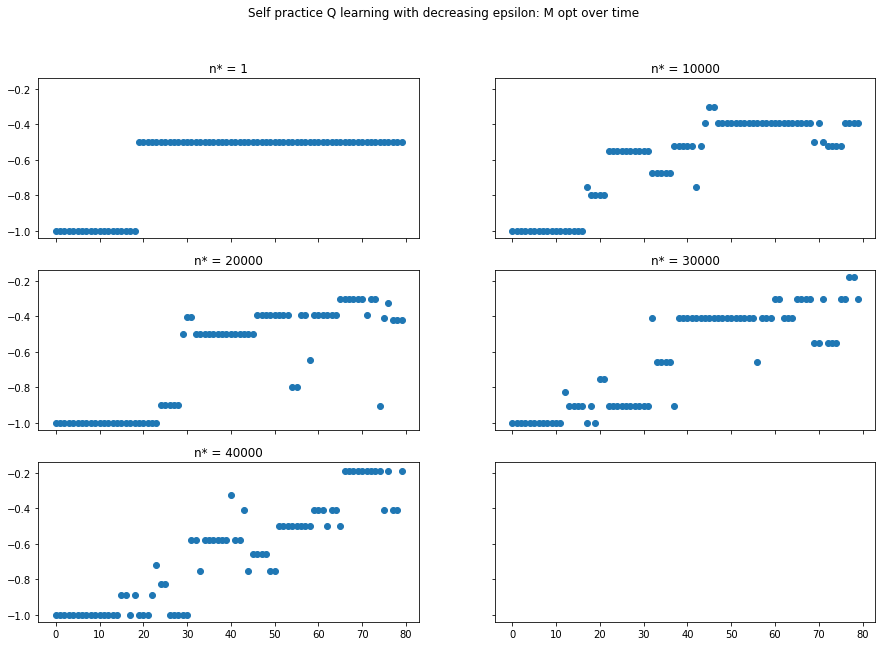

In [45]:
m_optimals = [r['m opt'] for r in results]
fig, axs = plt.subplots(3, 2,figsize=(15, 10), sharex=True, sharey=True)
for i in range(5):
    axs[(int(i/2), i % 2)].scatter(range(len(m_optimals[i])),m_optimals[i])
    axs[(int(i/2), i % 2)].set_title("n* = {}".format(n_stars[i]))
fig.suptitle("Self practice Q learning with decreasing epsilon: M opt over time");

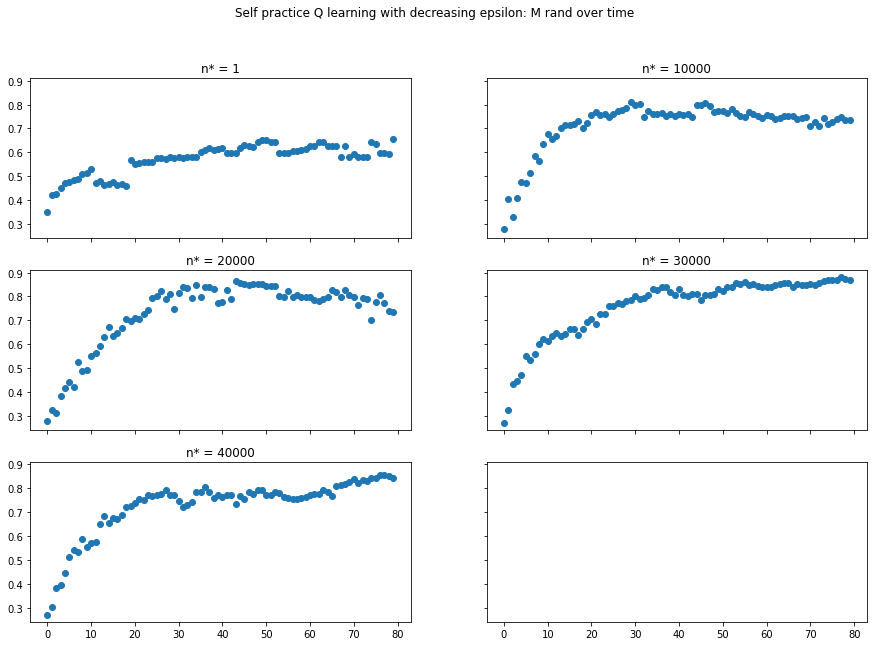

In [46]:
m_randoms = [r['m rand'] for r in results]
fig, axs = plt.subplots(3, 2,figsize=(15, 10), sharex=True, sharey=True)
for i in range(5):
    axs[(int(i/2), i % 2)].scatter(range(len(m_randoms[i])),m_randoms[i])
    axs[(int(i/2), i % 2)].set_title("n* = {}".format(n_stars[i]))
fig.suptitle("Self practice Q learning with decreasing epsilon: M rand over time");

### Question 9
M opt and M rand seems to be the highest when n\* is set to be 40000, in this case $M_{opt}= - 0.2$ and $M_{rand} = 0.85$